In [11]:
from math import sqrt
import random as rand
import numpy as np
import matplotlib.pyplot as plt

BOLTZMANN_CONSTANT = 1.38064852e-23

def maxwell_boltzmann_sampler(temperature, mass):
    v_rms = sqrt((3.0 * BOLTZMANN_CONSTANT * temperature) / (mass * 1.66053906660e-27))
    v_x: float = rand.gauss(0, v_rms)/2
    v_y: float = rand.gauss(0, v_rms)/2
    v_z: float = rand.gauss(0, v_rms)/2
    length = sqrt(v_x ** 2 + v_y ** 2 + v_z ** 2)
    return length


def maxwell_boltzmann_distrabution(temperature, mass, velocity):
    return (mass / (2 * np.pi * BOLTZMANN_CONSTANT * temperature)) ** (3.0/2.0) * 4 * np.pi * velocity ** 2 * np.exp(-mass * velocity ** 2 / (2 * BOLTZMANN_CONSTANT * temperature))


        

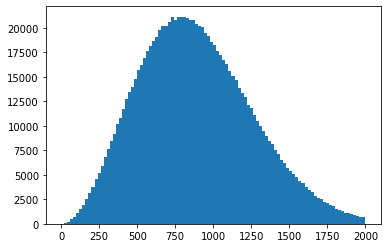

Mean velocity:  891.3824837996825


In [12]:
mass = 6
temperature = 300.0

velocities = np.array([maxwell_boltzmann_sampler(temperature, mass) for i in range(1000000)])

# Plot the distribution , limit the x axis to 0 to 1000 m/s
plt.hist(velocities, bins=100, range=(0, 2000))
plt.show()

print("Mean velocity: ", np.mean(velocities))


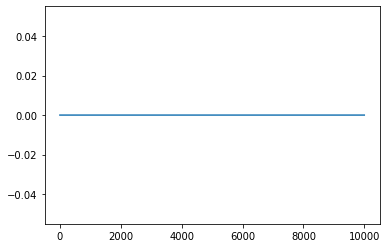

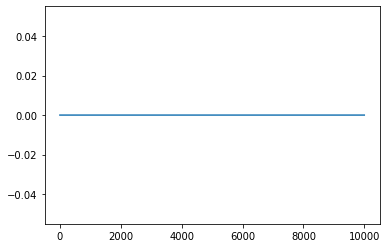

In [13]:
# plot the distribution
x = np.linspace(0, 10000, 10000)
y = [maxwell_boltzmann_distrabution(temperature, mass, v) for v in x]
plt.plot(x, y)
plt.show()

comulative = np.cumsum(y)
plt.plot(x, comulative)
plt.show()



In [14]:
import pandas as pd
import json

In [15]:
# example params
# 'Params { dt: 0.001, neghborhood_size: 11.4035, max_force: 2e32, friction: 0.0, box_size: 114.034996, bin_size: 11.4035, bin_count: 10, bin_capacity: 100, helium: Atom { size (nm): 2.2807, mass (u): 6.0, charge (q): 0, sigma (nm): 2.2807, epsilon (eV): 4.351708 } }    iteration\nUnnamed: 1                                                                                                                                                                                                                                                                     energy\nName: 0, dtype: object'

def strip_atom(atom) -> dict:
    # example atom
    # 'Atom { size (nm): 2.2807, mass (u): 6.0, charge (q): 0, sigma (nm): 2.2807, epsilon (eV): 4.351708 }'
    atom = atom[atom.find('{') + 1:atom.rfind('}')]
    atom = atom.split(',')
    atom = [a.strip() for a in atom]
    atom = [a.split(':') for a in atom]
    atom = {a[0]: a[1] for a in atom}
    # try to convert the values to floats
    for key in atom:
        try:
            atom[key] = float(atom[key])
        except ValueError:
            pass
    return atom

def strip_params(params) -> dict:
    # remove the everything before the first '{' and after the last '}'
    params = params[params.find('{')+1:]
    params = params[:params.rfind('}')-3]
    
    # extract the Atom objects
    params = params.split(', helium: ')
    helium = strip_atom(params[1])
    params = params[0]
    
    # split the params into a list of key value pairs
    params = params.split(',')
    params = [p.strip() for p in params]
    params = [p.split(':') for p in params]
    params = {p[0]: p[1] for p in params}
    for key in params:
        try:
            params[key] = float(params[key])
        except ValueError:
            pass
    params['helium'] = helium
    return params

In [16]:
def process(file, cutoff):
    # import the data (this is a csv file)
    data = pd.read_csv(f'../{file}.csv')
    params = data.iloc[0]
    params = strip_params(str(params))
    data.columns = ['iteration', 'energy']
    data = data.drop([0,1])

    data['iteration'] = data['iteration'].astype(int)
    data["time"] = data["iteration"] * params["dt"]

    data['energy'] = data['energy'].astype(float)
    data["energy_log"] = np.log(data["energy"])
    
    data = data[data['energy'] > cutoff]
    data['time'] = data['time'] - data['time'].iloc[0]
    
    return data, params


C:\Users\teun9\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\teun9\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\teun9\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\teun9\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\teun9\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\teun9\AppData\Roaming

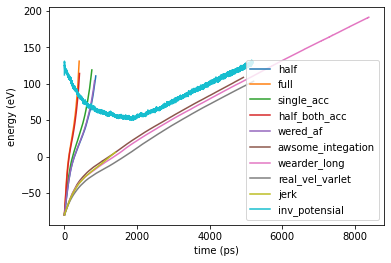

14.673
5.427
14.271
6.834
14.874
42.813
39.195


In [19]:

cutoff = -80.0
half, half_params = process('half_vel_verlet', cutoff)
full, full_params = process('full_vel_verlet', cutoff)
single_acc, single_acc_params = process('single_acc_full', cutoff)
half_both_acc, half_both_acc_params = process('half_both_acc', cutoff)    
wered_af, wered_af_params = process('wered_af', cutoff)
awsome_integation, awsome_integation_params = process('awsome_integation', cutoff)
wearder_long, wearder_long_params = process('wearder_long', cutoff)
real_verlet, real_verlet_params = process('real_vel_varlet', cutoff)
jerk, jerk_params = process('jerk', cutoff)
inv_potensial, inv_potensial_params = process('inv_potensial', cutoff)

# compare the two
plt.plot(half['time'], half['energy'], label='half')
plt.plot(full['time'], full['energy'], label='full')
plt.plot(single_acc['time'], single_acc['energy'], label='single_acc')
plt.plot(half_both_acc['time'], half_both_acc['energy'], label='half_both_acc')
plt.plot(wered_af['time'], wered_af['energy'], label='wered_af')
plt.plot(awsome_integation['time'], awsome_integation['energy'], label='awsome_integation')
plt.plot(wearder_long['time'], wearder_long['energy'], label='wearder_long')
plt.plot(real_verlet['time'], real_verlet['energy'], label='real_vel_varlet')
plt.plot(jerk['time'], jerk['energy'], label='jerk')
plt.plot(inv_potensial['time'], inv_potensial['energy'], label='inv_potensial')
plt.xlabel('time (ps)')
plt.ylabel('energy (eV)')
plt.legend()
plt.show()

# at what iteration is the energy at 0
print(half[half['energy'] < 0.0]['iteration'].iloc[0]/1000)
print(full[full['energy'] < 0.0]['iteration'].iloc[0]/1000)
print(single_acc[single_acc['energy'] < 0.0]['iteration'].iloc[0]/1000)
print(half_both_acc[half_both_acc['energy'] < 0.0]['iteration'].iloc[0]/1000)
print(wered_af[wered_af['energy'] < 0.0]['iteration'].iloc[0]/1000) 
print(awsome_integation[awsome_integation['energy'] < 0.0]['iteration'].iloc[0]/1000)
print(wearder_long[wearder_long['energy'] < 0.0]['iteration'].iloc[0]/1000)


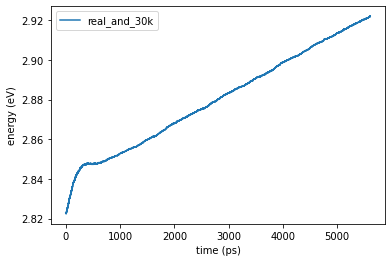

In [ ]:
real_and_30k, real_and_30k_params = process('real_and_30k', cutoff)

plt.plot(real_and_30k['time'], real_and_30k['energy'], label='real_and_30k')
plt.xlabel('time (ps)')
plt.ylabel('energy (eV)')
plt.legend()
plt.show()